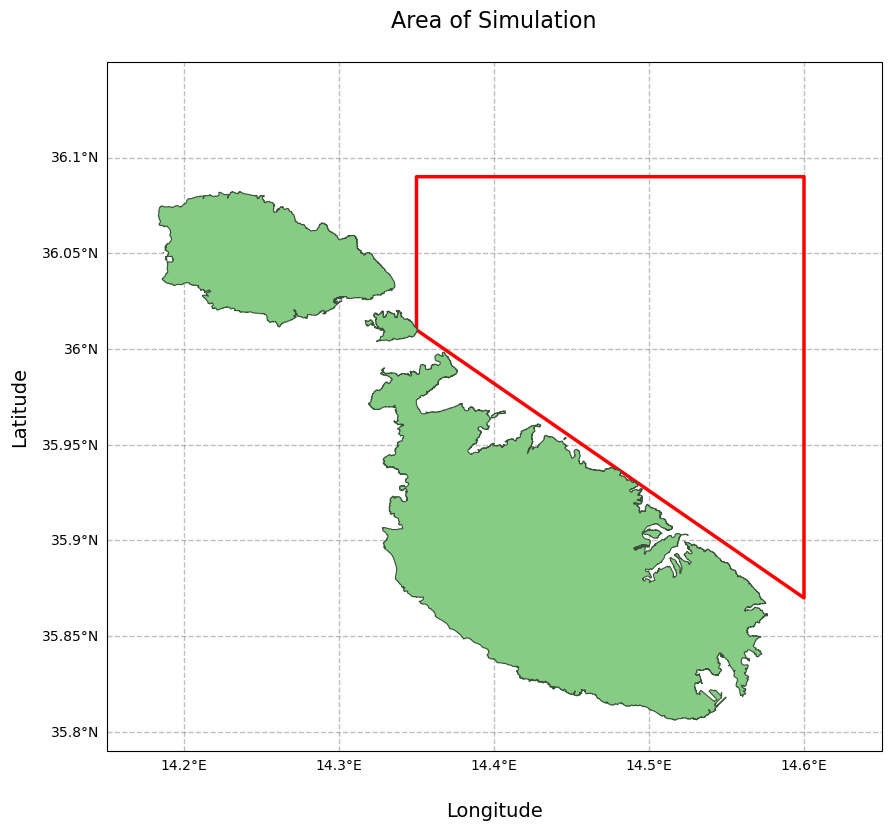

In [3]:
### First Visuslisation for the Article

import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
from shapely.geometry import Polygon

# Path to the shapefile
shapefile_path = '../Data/land_sea_mask/MaltaCoastline.shp'

# Load the shapefile using GeoPandas and ensure it's in WGS84 CRS
gdf = gpd.read_file(shapefile_path).to_crs(epsg=4326)

# Define the vertices of a polygon to highlight a specific area on the map
polygon_coordinates = [
    (14.6, 35.87),
    (14.35, 36.01),
    (14.35, 36.09),
    (14.6, 36.09),
    (14.6, 35.87)
]
polygon_shape = Polygon(polygon_coordinates)

# Define the geographic boundaries for plotting
extent = [14.15, 14.65, 35.79, 36.15]

# Prepare the plot with a geographic (Plate Carree) projection
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent(extent)

# Plot the coastline of Malta from the shapefile using GeoPandas
gdf.plot(ax=ax, color='#86CC85', edgecolor='#3B533B', linewidth=0.8, zorder=4)

# Add the polygon to the map
ax.add_geometries([polygon_shape], ccrs.PlateCarree(), facecolor='none', edgecolor='red', linewidth=2.5, zorder=3)

# Add gridlines and labels to improve map readability
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Customize the plot appearance
plt.title("Area of Simulation", pad=25, fontsize=16)
ax.text(-0.1, 0.50, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=14)
ax.text(0.5, -0.1, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=14)

# Specify the filename and dpi for saving the figure
plt.savefig('DingliMark_20703H_Image1.jpeg', dpi=300, bbox_inches='tight')
 
# Display the plot
plt.show()

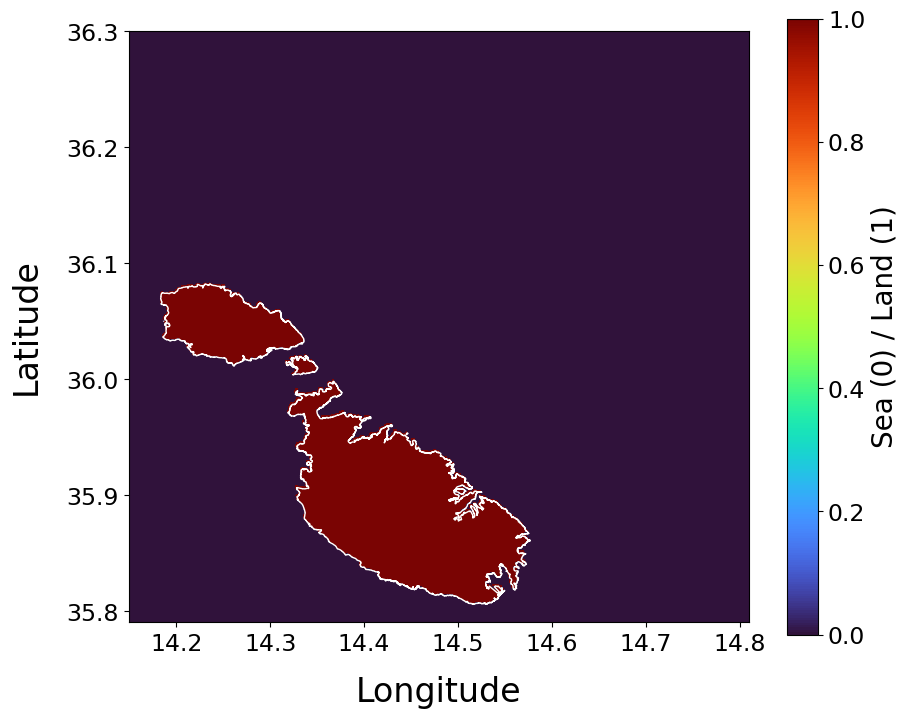

In [4]:
import numpy as np
import rasterio
from rasterio.features import rasterize
import xarray as xr
import matplotlib.pyplot as plt

# Set font sizes using rcParams
plt.rcParams.update({'font.size': 12})  # Adjust the base font size for all text
plt.rcParams['axes.labelsize'] = 24    # Font size for axes labels
plt.rcParams['xtick.labelsize'] = 17   # Font size for the tick labels on x-axis
plt.rcParams['ytick.labelsize'] = 17   # Font size for the tick labels on y-axis

# Convert GeoDataFrame projection to WGS 84 for compatibility
gdf = gdf.to_crs(epsg=4326)

# Define the geographical bounds for the simulation area
lon_min, lat_min, lon_max, lat_max = 14.15, 35.79, 14.81, 36.3

# Set the resolution of the grid in kilometers (0.1 km)
resolution_km = 0.1

# Calculate the resolution in degrees based on the latitude
mean_lat = (lat_min + lat_max) / 2
km_per_degree = np.cos(mean_lat * np.pi / 180) * 111.32
resolution_degrees = resolution_km / km_per_degree

# Determine the number of grid cells needed based on the area's dimensions and resolution
num_lons = int(np.ceil((lon_max - lon_min) / resolution_degrees))
num_lats = int(np.ceil((lat_max - lat_min) / resolution_degrees))

# Generate transformation parameters for converting lat/lon to grid coordinates
transform = rasterio.transform.from_origin(lon_min, lat_max, resolution_degrees, resolution_degrees)

# Convert the shapefile to a raster format using the specified grid resolution
raster = rasterize(
    [(geom, 1) for geom in gdf.geometry],  # Assign a value of 1 to all shapes
    out_shape=(num_lats, num_lons),  # Shape of the output raster
    transform=transform,  # Transformation parameters
    fill=0,  # Fill value outside shapes (representing sea)
    all_touched=True  # Include all pixels touched by geometries
)

# Generate arrays of longitude and latitude values corresponding to the grid
lons = np.linspace(lon_min, lon_max, num_lons, endpoint=False)
lats = np.linspace(lat_max, lat_min, num_lats, endpoint=False)[::-1]

# Create an xarray Dataset with the land-sea mask, using the generated raster grid
ds = xr.Dataset(
    {
        'land_sea_mask': (['lat', 'lon'], raster)
    },
    coords={
        'lon': lons,
        'lat': lats
    }
)

# Plot the generated land-sea mask to visually verify its accuracy
plt.figure(figsize=(10, 8))
plt.pcolormesh(lons, lats[::-1], raster, cmap='turbo')
cbar = plt.colorbar(label='Sea (0) / Land (1)')
cbar.ax.set_ylabel('Sea (0) / Land (1)', fontsize=20)  # Set colorbar label size
plt.xlabel('Longitude', labelpad=15)  # Shift the longitude label to the left
plt.ylabel('Latitude', labelpad=17)  # Shift the latitude label downward

# Overlay the original shapefile on the raster to check alignment
gdf.plot(ax=plt.gca(), color='none', edgecolor='white')

# Save the plot as a png file with specified DPI and bounding box tightness
pdf_filename = "land_sea_mask_malta.png"
plt.savefig(pdf_filename, dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

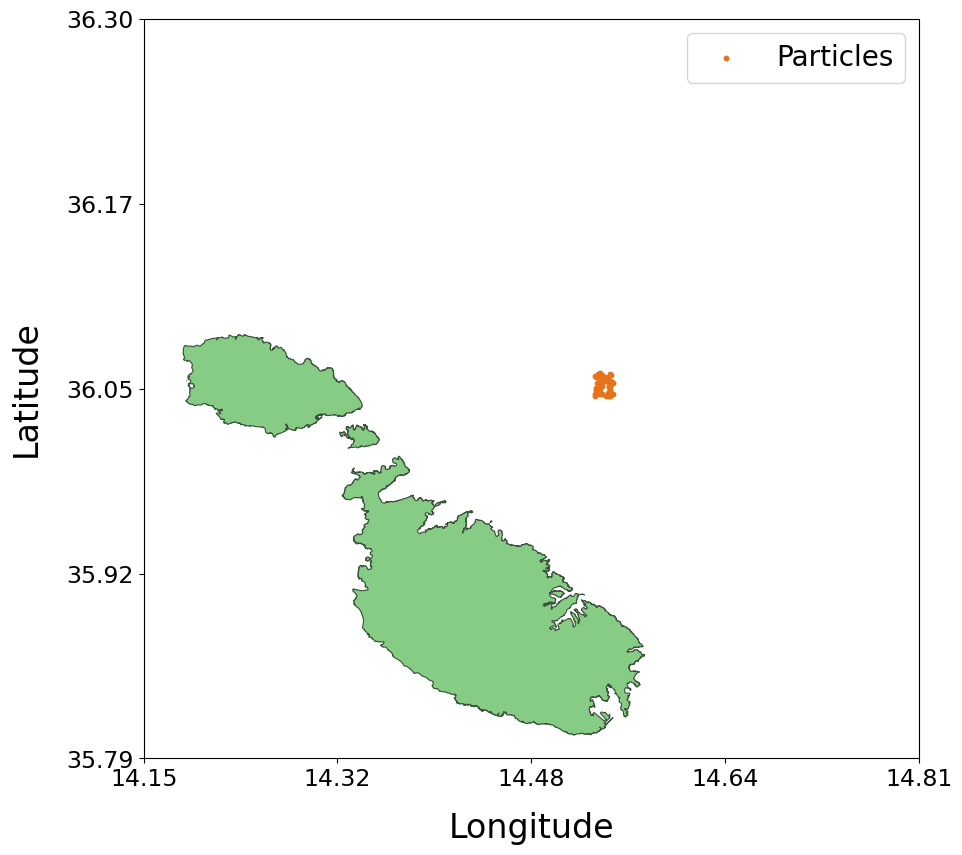

In [26]:
# Number of particles to simulate
num_particles = 50

# Geographic coordinates for the starting point of all particles
start_lat = 36.0475
start_lon = 14.5417

# Range for generating random offsets for the particles
offset_range = 0.008  

# Generate random offsets for longitude and latitude to simulate initial dispersion
lon_offsets = np.random.uniform(-offset_range, offset_range, num_particles)
lat_offsets = np.random.uniform(-offset_range, offset_range, num_particles)

# Apply these offsets to the starting point to get initial positions
lon_release = start_lon + lon_offsets
lat_release = start_lat + lat_offsets

# Define the geographic boundaries for plotting
extent = [14.15, 14.81, 35.79, 36.3]

# Prepare the plot with a geographic (Plate Carree) projection
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent(extent)

# Plot the coastline of Malta from a shapefile using GeoPandas
gdf.plot(ax=ax, color='#86CC85', edgecolor='#3B533B', linewidth=0.8, zorder=2)

# Plot the initial positions of the particles on the map
scatter = ax.scatter(lon_release, lat_release, s=10, c="#e8721a", marker='o', transform=ccrs.PlateCarree(), label='Particles')

# Define and set ticks for longitude and latitude to improve map readability
lon_ticks = np.linspace(extent[0], extent[1], num=5) 
lat_ticks = np.linspace(extent[2], extent[3], num=5) 
ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{tick:.2f}' for tick in lon_ticks])
ax.set_yticklabels([f'{tick:.2f}' for tick in lat_ticks])

# Add additional plot elements 
plt.xlabel('Longitude', labelpad=15)  # Shift the longitude label to the left
plt.ylabel('Latitude', labelpad=17)  # Shift the latitude label downward
plt.legend(fontsize=20)  

# Save the plot as a PDF file with specified DPI and bounding box tightness
pdf_filename = "initial_particle_locations.png"
plt.savefig(pdf_filename, dpi=300, bbox_inches='tight')

# Display the plot
plt.show() 

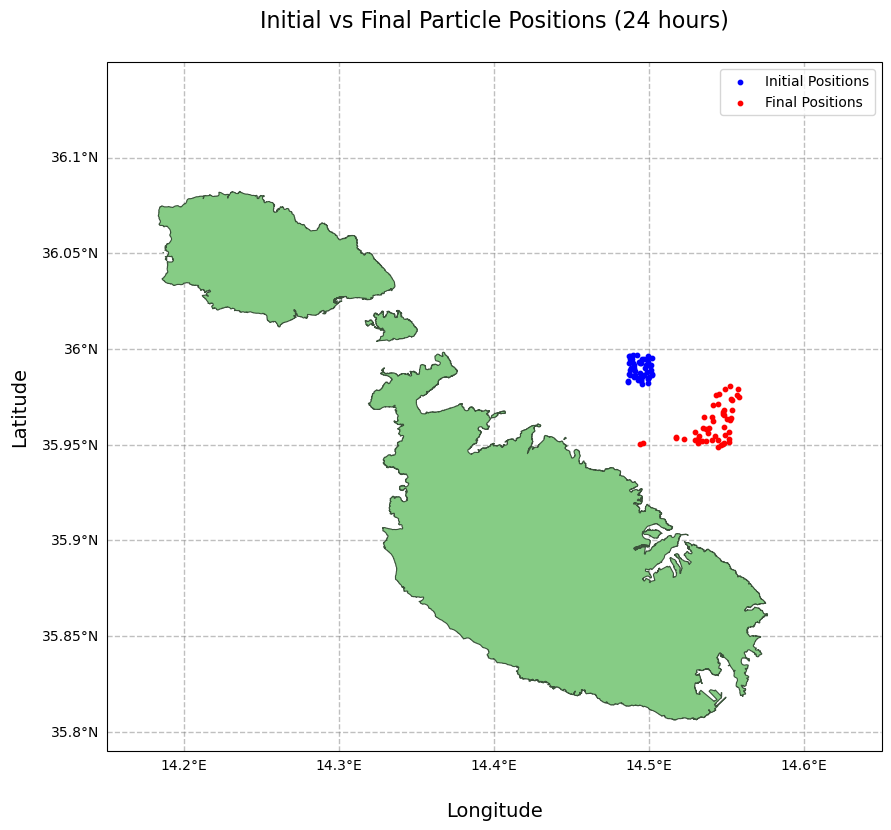

In [2]:
### Second Visuslisation for the Article

import xarray as xr

# Load the shapefile using GeoPandas and ensure it's in WGS84 CRS
shapefile_path = '../Data/land_sea_mask/MaltaCoastline.shp'
gdf = gpd.read_file(shapefile_path).to_crs(epsg=4326)

# Load the predicted particle data
predicted_ds = xr.open_zarr("../Lagrangian_Output/LSTM_predicted_values.zarr")

# Calculate initial and final positions
initial_lons = predicted_ds.lon.isel(obs=0).values  # Initial longitudes
initial_lats = predicted_ds.lat.isel(obs=0).values  # Initial latitudes
final_lons = predicted_ds.lon.isel(obs=-1).values  # Final longitudes
final_lats = predicted_ds.lat.isel(obs=-1).values  # Final latitudes

# Define the geographic boundaries for the plot
extent = [14.15, 14.65, 35.79, 36.15]

# Prepare the plot with a geographic (Plate Carree) projection
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent(extent)

# Plot the coastline of Malta from the shapefile using GeoPandas
gdf.plot(ax=ax, color='#86CC85', edgecolor='#3B533B', linewidth=0.8, zorder=4)

# Plot the initial positions of the particles on the map
ax.scatter(initial_lons, initial_lats, s=10, c='blue', marker='o', transform=ccrs.PlateCarree(), label='Initial Positions', zorder=3)

# Plot the final positions of the particles on the map
ax.scatter(final_lons, final_lats, s=10, c='red', marker='o', transform=ccrs.PlateCarree(), label='Final Positions', zorder=3)

# Customize the plot appearance
ax.set_title("Initial vs Final Particle Positions (24 hours)", pad=25, fontsize=16)
ax.text(-0.1, 0.50, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=14)
ax.text(0.5, -0.1, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=14)
ax.legend(loc='upper right')

# Add gridlines and labels to improve map readability
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Specify the filename and dpi for saving the figure
plt.savefig('DingliMark_20703H_Image2.jpeg', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

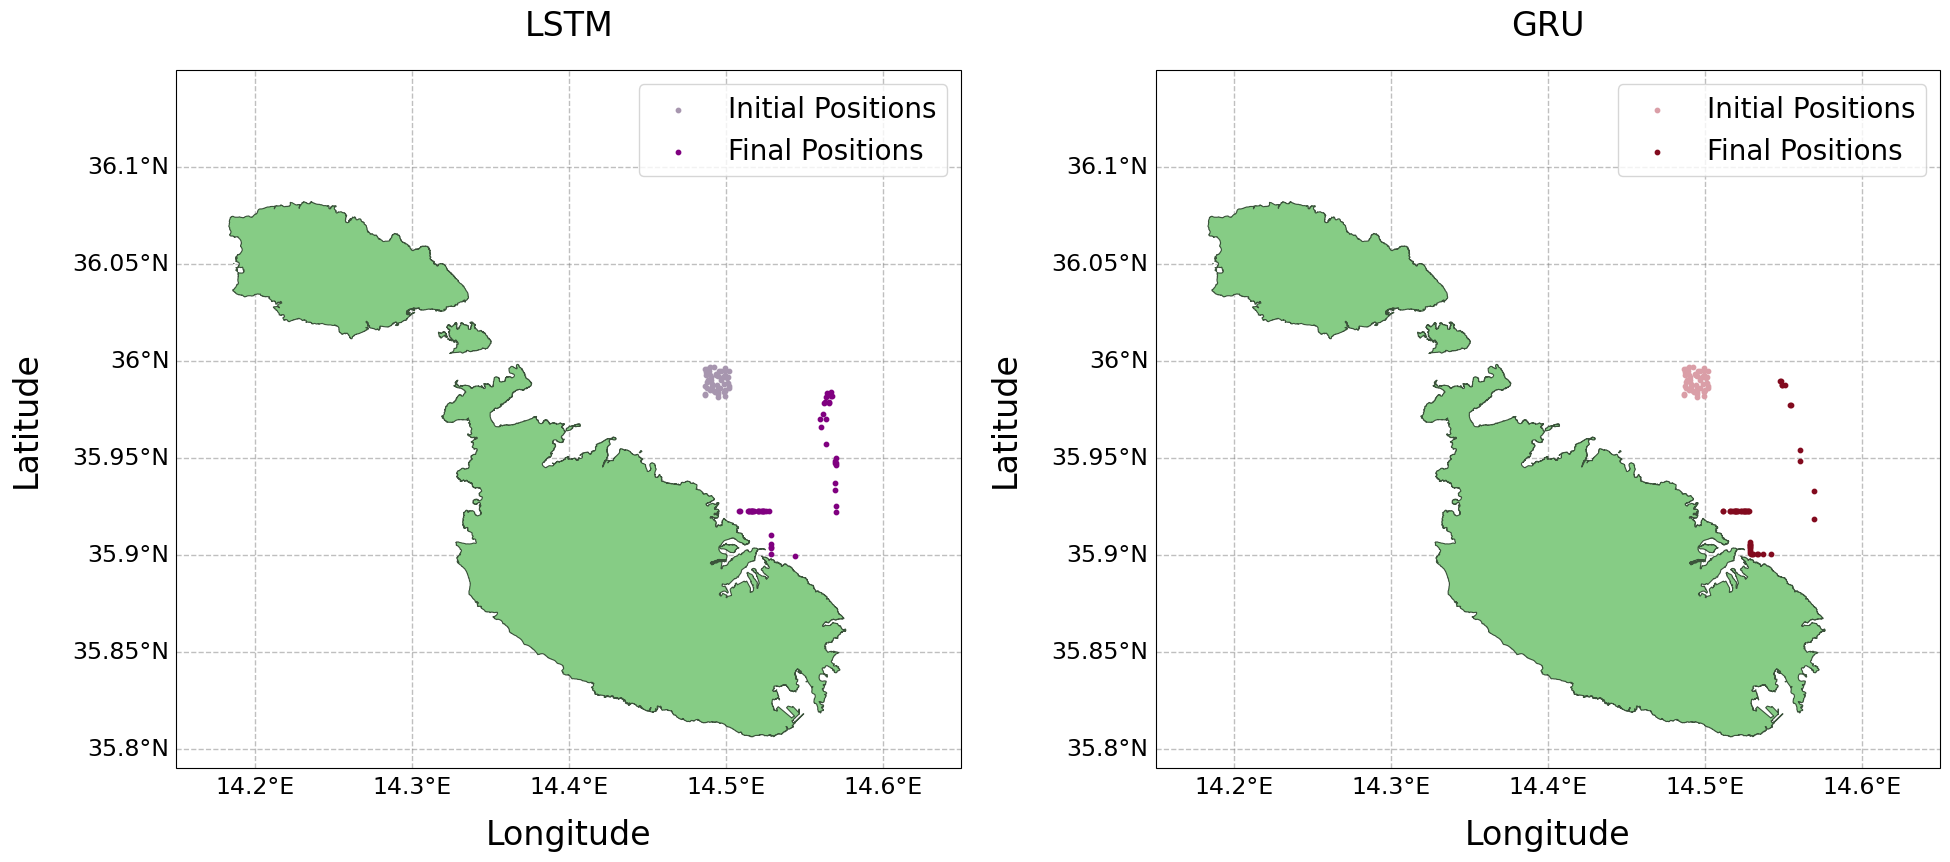

In [2]:
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Load the shapefile using GeoPandas and ensure it's in WGS84 CRS
shapefile_path = '../Data/land_sea_mask/MaltaCoastline.shp'
gdf = gpd.read_file(shapefile_path).to_crs(epsg=4326)

# Load the predicted particle data for LSTM and GRU
predicted_lstm = xr.open_zarr("../Lagrangian_Output/LSTM_predicted_values_2.zarr")
predicted_gru = xr.open_zarr("../Lagrangian_Output/GRU_predicted_values_2.zarr")

# Define the geographic boundaries for the plot
extent = [14.15, 14.65, 35.79, 36.15]

# Set up the figure and axes with a geographic (Plate Carree) projection
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax1.set_extent(extent)
ax2.set_extent(extent)

# Colors for initial and final markers
colors_lstm = {'initial': '#A796AF', 'final': 'purple'}
colors_gru = {'initial': '#DA9EA7', 'final': '#820A1E'}

# Plot function to avoid code duplication
def plot_positions(ax, data, title, colors):
    initial_lons = data.lon.isel(obs=0).values  # Initial longitudes
    initial_lats = data.lat.isel(obs=0).values  # Initial latitudes
    final_lons = data.lon.isel(obs=-1).values  # Final longitudes
    final_lats = data.lat.isel(obs=-1).values  # Final latitudes

    # Plot the coastline of Malta from the shapefile using GeoPandas
    gdf.plot(ax=ax, color='#86CC85', edgecolor='#3B533B', linewidth=0.8, zorder=4)

    # Plot the initial positions of the particles on the map
    ax.scatter(initial_lons, initial_lats, s=10, c=colors['initial'], marker='o', label='Initial Positions', transform=ccrs.PlateCarree(), zorder=3)

    # Plot the final positions of the particles on the map
    ax.scatter(final_lons, final_lats, s=10, c=colors['final'], marker='o', label='Final Positions', transform=ccrs.PlateCarree(), zorder=3)

    # Customize the plot appearance
    ax.legend(loc='upper right', fontsize = 20)

    # Add gridlines and labels to improve map readability
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 17}  # Increasing font size for longitude labels
    gl.ylabel_style = {'size': 17}  # Increasing font size for latitude labels

    # Customize the plot appearance
    ax1.set_title("LSTM", pad=25, fontsize=24)
    ax2.set_title("GRU", pad=25, fontsize=24)
    ax.text(-0.17, 0.50, 'Latitude', va='bottom', ha='center',
            rotation='vertical', rotation_mode='anchor',
            transform=ax.transAxes, fontsize = 24)
    ax.text(0.5, -0.12, 'Longitude', va='bottom', ha='center',
            rotation='horizontal', rotation_mode='anchor',
            transform=ax.transAxes, fontsize = 24)
    
# Plot LSTM and GRU predictions
plot_positions(ax1, predicted_lstm, "LSTM", colors_lstm)
plot_positions(ax2, predicted_gru, "GRU", colors_gru)

# Customize layout
plt.tight_layout(pad=3)

# Specify the filename and dpi for saving the figure
plt.savefig('LSMT_and_GRU_initial_vs_final_debris_movement_(November).png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

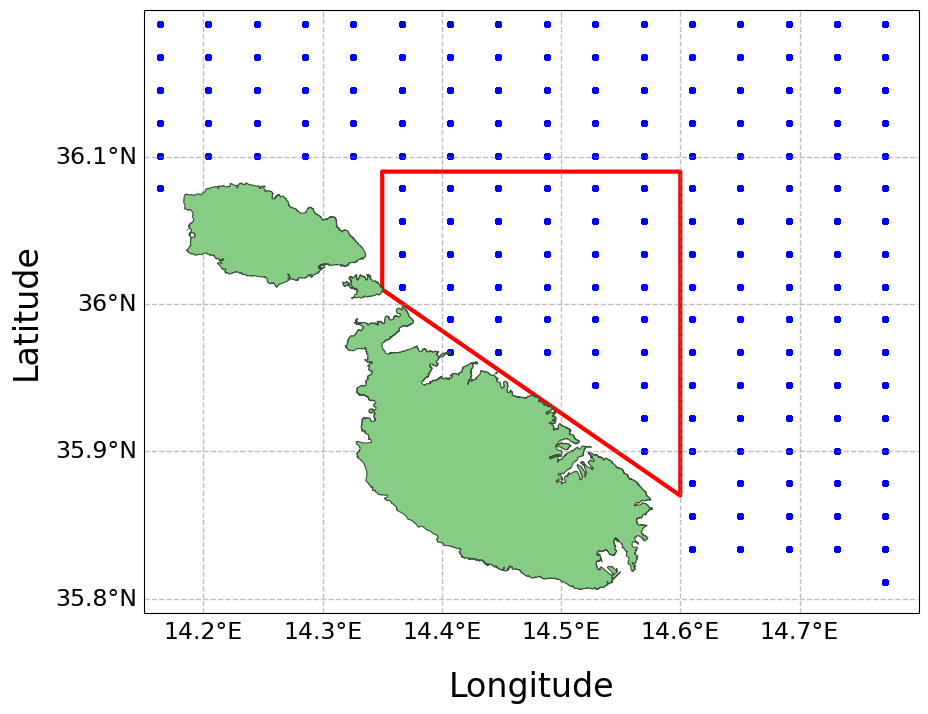

In [5]:
import pandas as pd

# Load the dataset
netcdf_file_path = "../Data/model_IO/final_SSC_Data.nc"

# Open the dataset
dataset = xr.open_dataset(netcdf_file_path)

# Convert the dataset to a pandas DataFrame and reset the index
df = dataset.to_dataframe().reset_index()

# Drop unnecessary columns from the DataFrame
df = df.drop(columns=['stdu', 'stdv', 'cov', 'velo', 'head'])

# Drop rows with NaN values in 'u' and 'v' columns
df.dropna(subset=['u', 'v'], inplace=True)

# Convert the 'time' column to datetime format
df.index = pd.to_datetime(df['time'], format='%d-%m-%Y %H:%M:%S')

# Define the boundaries for the map
boundaries = {
    'min_lon': 14.15,
    'max_lon': 14.8,
    'min_lat': 35.79,
    'max_lat': 36.2
}

# Define the vertices of a polygon to highlight a specific area on the map
polygon_coordinates = [
    (14.6, 35.87),
    (14.35, 36.01),
    (14.35, 36.09),
    (14.6, 36.09),
    (14.6, 35.87)
]

# Load the shapefile using GeoPandas
shapefile_path = '../Data/land_sea_mask/MaltaCoastline.shp'
gdf = gpd.read_file(shapefile_path).to_crs(epsg=4326)

# Prepare the plot with a geographic (Plate Carree) projection
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([boundaries['min_lon'], boundaries['max_lon'], boundaries['min_lat'], boundaries['max_lat']])

# Plot the coastline of Malta using GeoPandas
gdf.plot(ax=ax, color='#86CC85', edgecolor='#3B533B', linewidth=0.8, zorder=3)

# Plot all data points within the defined geographic boundaries
ax.scatter(df['lon'], df['lat'], s=12, color='blue', marker='o', alpha=0.5, transform=ccrs.Geodetic())

# Create and add the polygon to the map
polygon_shape = Polygon(polygon_coordinates)
ax.add_geometries([polygon_shape], ccrs.PlateCarree(), facecolor='none', edgecolor='red', linewidth=3)

# Customize the plot appearance
ax.text(-0.13, 0.50, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize = 24)
ax.text(0.5, -0.15, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize = 24)

# Add gridlines to the map
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 17}  # Increasing font size for longitude labels
gl.ylabel_style = {'size': 17}  # Increasing font size for latitude labels

# Save the figure as a PNG file
plt.savefig('all_data_points_and_selected_area_of_interest.png', bbox_inches='tight', dpi=300)

# Display the plot
plt.show()

c:\Users\markd\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3490: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


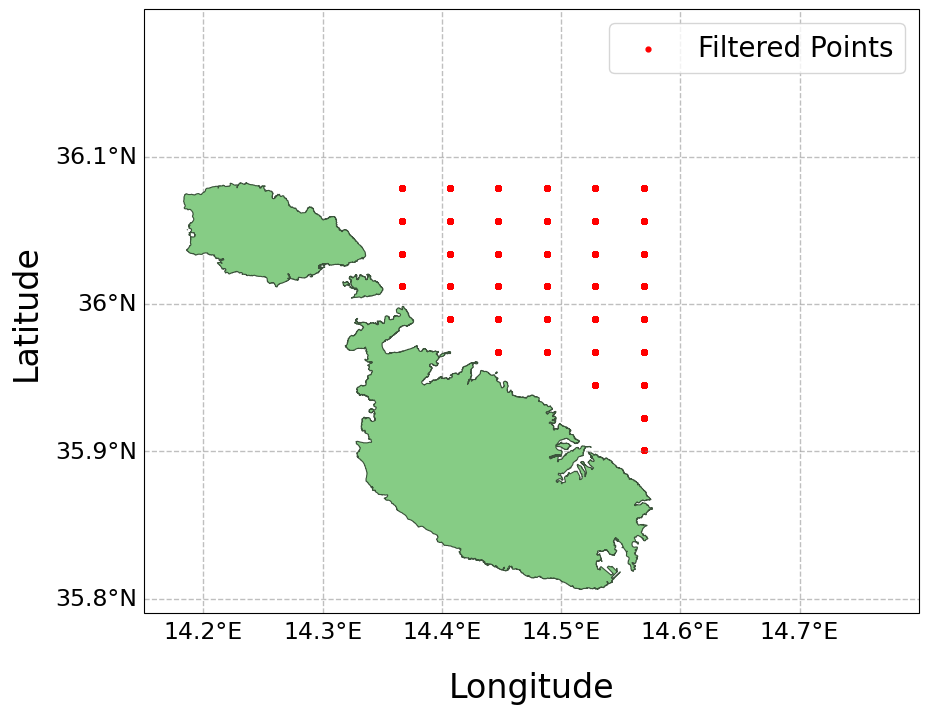

In [6]:
# Convert your polygon into a GeoDataFrame
polygon_gdf = gpd.GeoDataFrame(index=[0], geometry=[polygon_shape], crs="EPSG:4326")

# Convert the DataFrame to a GeoDataFrame
gdf_points = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326")

# Use spatial join to find points within the polygon
df_inside_polygon = gpd.sjoin(gdf_points, polygon_gdf, how="inner", op='within')

# Plotting
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([boundaries['min_lon'], boundaries['max_lon'], boundaries['min_lat'], boundaries['max_lat']])

# Plot the coastline of Malta from the shapefile using GeoPandas
gdf.plot(ax=ax, color='#86CC85', edgecolor='#3B533B', linewidth=0.8, zorder=3)

# Plot the points that are located within the defined polygon in red
df_inside_polygon.plot(ax=ax, color='red', markersize=12, label='Filtered Points', transform=ccrs.Geodetic())

# Customize the plot appearance
ax.text(-0.13, 0.50, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize = 24)
ax.text(0.5, -0.15, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize = 24)
ax.legend(loc='upper right', fontsize = 20)

# Add gridlines to the map
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 17}  # Increasing font size for longitude labels
gl.ylabel_style = {'size': 17}  # Increasing font size for latitude labels

# Save the figure as a png file
plt.savefig('filtered_points_within_area_of_interest.png', bbox_inches='tight', dpi=300)

# Display the plot
plt.show()

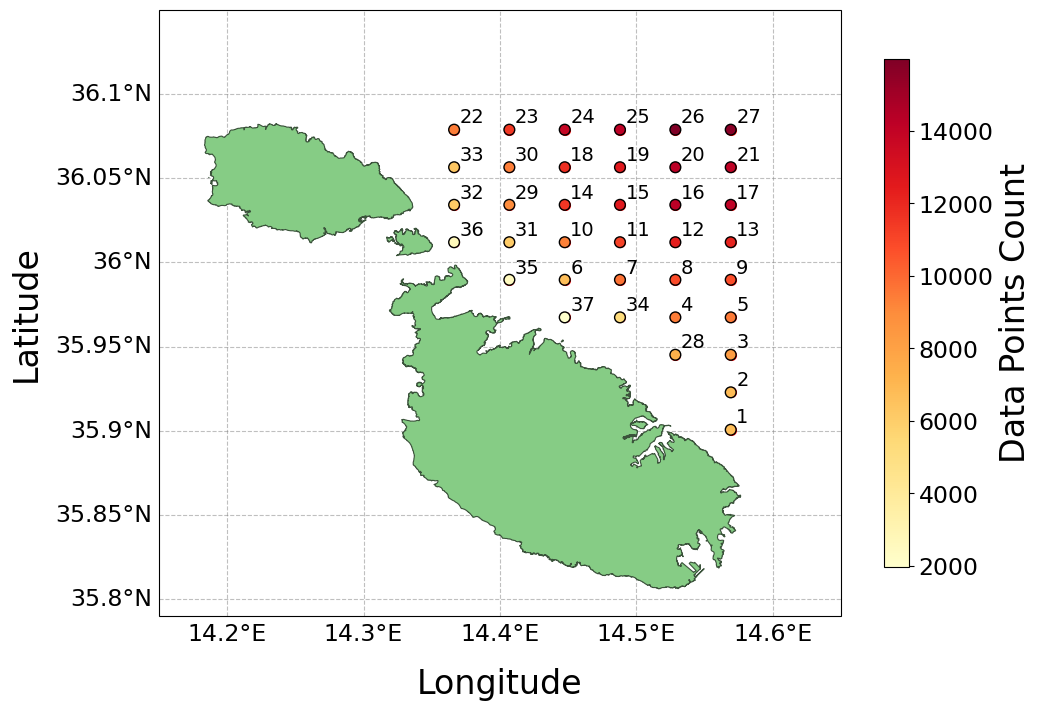

In [24]:
latitude = [
    35.90060043334961, 35.92279815673828, 35.945098876953125,
    35.96730041503906, 35.96730041503906, 35.989601135253906,
    35.989601135253906, 35.989601135253906, 35.989601135253906,
    36.01190185546875, 36.01190185546875, 36.01190185546875,
    36.01190185546875, 36.03409957885742, 36.03409957885742,
    36.03409957885742, 36.03409957885742, 36.056400299072266,
    36.056400299072266, 36.056400299072266, 36.056400299072266,
    36.07870101928711, 36.07870101928711, 36.07870101928711,
    36.07870101928711, 36.07870101928711, 36.07870101928711,
    35.945098876953125, 36.03409957885742, 36.056400299072266,
    36.01190185546875, 36.03409957885742, 36.056400299072266,
    35.96730041503906, 35.989601135253906, 36.01190185546875,
    35.96730041503906
]

longitude = [
    14.569199562072754, 14.569199562072754, 14.569199562072754,
    14.528599739074707, 14.569199562072754, 14.447500228881836,
    14.48799991607666, 14.528599739074707, 14.569199562072754,
    14.447500228881836, 14.48799991607666, 14.528599739074707,
    14.569199562072754, 14.447500228881836, 14.48799991607666,
    14.528599739074707, 14.569199562072754, 14.447500228881836,
    14.48799991607666, 14.528599739074707, 14.569199562072754,
    14.366399765014648, 14.406900405883789, 14.447500228881836,
    14.48799991607666, 14.528599739074707, 14.569199562072754,
    14.528599739074707, 14.406900405883789, 14.406900405883789,
    14.406900405883789, 14.366399765014648, 14.366399765014648,
    14.48799991607666, 14.406900405883789, 14.366399765014648,
    14.447500228881836
]

# Define a dictionary containing the latitude, longitude, and an identifier number for each data point
data = {
    'Latitude': latitude,
    'Longitude': longitude,
    'Number': list(range(1, 38))
}

# Load the shapefile for Malta's coastline 
shapefile_path = '../Data/land_sea_mask/MaltaCoastline.shp'
malta_coastline = gpd.read_file(shapefile_path).to_crs(epsg=4326)

# Initialize a matplotlib figure with a geographic projection (Plate Carree) to display maps and data with latitude and longitude
fig, ax = plt.subplots(figsize=(11, 11), subplot_kw={'projection': ccrs.PlateCarree()})

# Set the geographic extent of the plot 
ax.set_extent([14.15, 14.65, 35.79, 36.15])

# Plot Malta's coastline on the map 
malta_coastline.plot(ax=ax, color='#86CC85', edgecolor='#3B533B', linewidth=0.8, zorder=4)

# Convert the data dictionary into a pandas DataFrame and add the 'Count' column to represent the number of data points at each location
df = pd.DataFrame(data)
df['Count'] = [
    6694, 6804, 8293, 9458, 9507, 6729, 9718, 10792, 10783,
    9350, 11153, 12368, 12187, 11500, 12616, 14282, 14072,
    11792, 12634, 14282, 14120, 9464, 11484, 13834, 14137,
    15989, 15703, 7301, 8998, 9364, 6111, 6154, 6324, 5224,
    2489, 2683, 1964
]

# Plot each point on the map. Numbers are displayed next to each point for identification
for lat, lon, number in zip(data['Latitude'], data['Longitude'], data['Number']):
    ax.plot(lon, lat, marker='o', color='red', markersize=7, transform=ccrs.Geodetic())
    offset_lat = 0.004
    offset_lon = 0.004
    ax.text(lon + offset_lon, lat + offset_lat, str(number), transform=ccrs.Geodetic(), fontsize=14, zorder=5)

# Create the heatmap using a scatter plot, using the actual count values for the color
scatter = ax.scatter(
    df['Longitude'], df['Latitude'],
    s=60,  
    c=df['Count'],  
    cmap='YlOrRd',  
    edgecolor='k',  
    transform=ccrs.Geodetic(),
    zorder=3  
)

# Add colorbar to the right of the plot, using the actual count values
cbar = plt.colorbar(scatter, ax=ax, shrink=0.6)
cbar.set_label('Data Points Count')

# Add gridlines and labels to improve map readability
gl = ax.gridlines(draw_labels=True, linewidth=0.8, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 17}  # Increasing font size for longitude labels
gl.ylabel_style = {'size': 17}  # Increasing font size for latitude labels

# Customize the plot appearance
ax.text(-0.17, 0.50, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize = 24)
ax.text(0.5, -0.14, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize = 24)

# Save the figure as a png file
plt.savefig('amount_of_data_points_per_coordinate.png', bbox_inches='tight', dpi=300)

# Display the plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


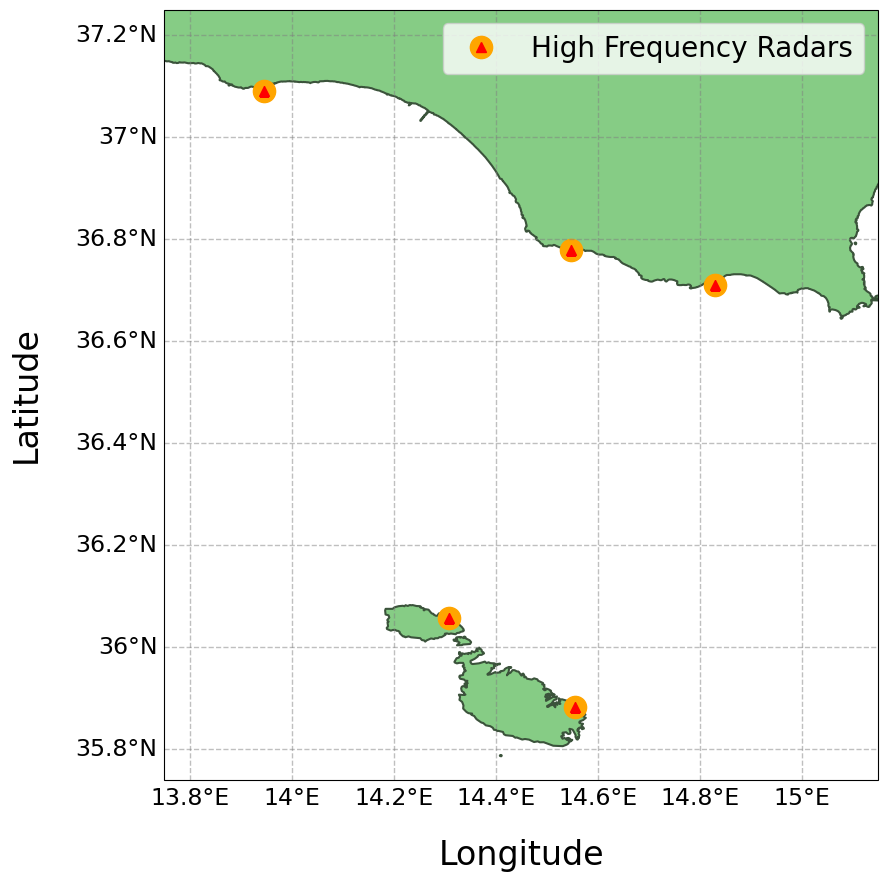

In [2]:
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from matplotlib.lines import Line2D  
from matplotlib.legend_handler import HandlerTuple
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs

# Define the path to your shapefile.
shapefile_path = "../Data/land_sea_mask/sicily/iho.shp"

# Set the extent of your map (longitude and latitude boundaries).
extent = [13.75, 15.15, 35.74, 37.25]

# Create a figure object and set the size.
fig = plt.figure(figsize=(14, 10))

# Create a GeoAxes object with the Plate Carree projection.
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Set the extent using the predefined bounding box.
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Set the background color of the axes to green (representing land).
ax.set_facecolor('#86CC85')

# Read the shapefile using the Reader and create a ShapelyFeature.
shape_feature = ShapelyFeature(Reader(shapefile_path).geometries(),
                               ccrs.PlateCarree(), edgecolor='#3B533B', facecolor='white', linewidth=1.5)

# Add the shapefile feature to the axes.
ax.add_feature(shape_feature)

# Customize the plot appearance
ax.text(-0.17, 0.50, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize = 24)
ax.text(0.5, -0.12, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize = 24)
ax.legend(loc='upper right')

# Add gridlines to the map
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 17}  # Increasing font size for longitude labels
gl.ylabel_style = {'size': 17}  # Increasing font size for latitude labels

# Radar points to be added to the map, defined as (Longitude, Latitude).
radar_points = [
    (13.9456, 37.0894),
    (14.5483, 36.7778),
    (14.8300, 36.7106),
    (14.3083, 36.0564),
    (14.5561, 35.8825),
]

radar_plots = []
for lon, lat in radar_points:
    # First, plot the aura using a larger, semi-transparent marker
    ax.plot(lon, lat, marker='o', color='orange', markersize=16, alpha=1, transform=ccrs.Geodetic())
    
    # Then, plot the radar point on top with a smaller, opaque marker
    point, = ax.plot(lon, lat, marker='^', color='red', markersize=7, alpha=1, transform=ccrs.Geodetic(), label="High Frequency Radars")
    radar_plots.append(point)

# Define the custom handler
class CustomHandler(HandlerTuple):
    def create_artists(self, legend, orig_handle, x0, y0, width, height, fontsize, trans):
        # Create the aura circle
        aura = Line2D([x0 + width / 2.], [y0 + height / 2.], marker='o', color='orange', 
                      markerfacecolor='orange', markersize=16, alpha=1)
        # Create the radar triangle
        triangle = Line2D([x0 + width / 2.], [y0 + height / 2.], marker='^', color='red', 
                          markerfacecolor='red', markersize=7, alpha=1)
        return [aura, triangle]

# Create the custom legend elements as a tuple
legend_elements = (Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=16, alpha=1),
                   Line2D([0], [0], marker='^', color='w', markerfacecolor='red', markersize=7, alpha=1))

# Add the legend to the plot with the custom handler
ax.legend([legend_elements], ['High Frequency Radars'], handler_map={legend_elements: CustomHandler()}, loc='upper right', fontsize=20)

# Save the figure as a PNG file
plt.savefig('radar_locations.pdf', bbox_inches='tight', dpi=300)

# Display the plot.
plt.show()

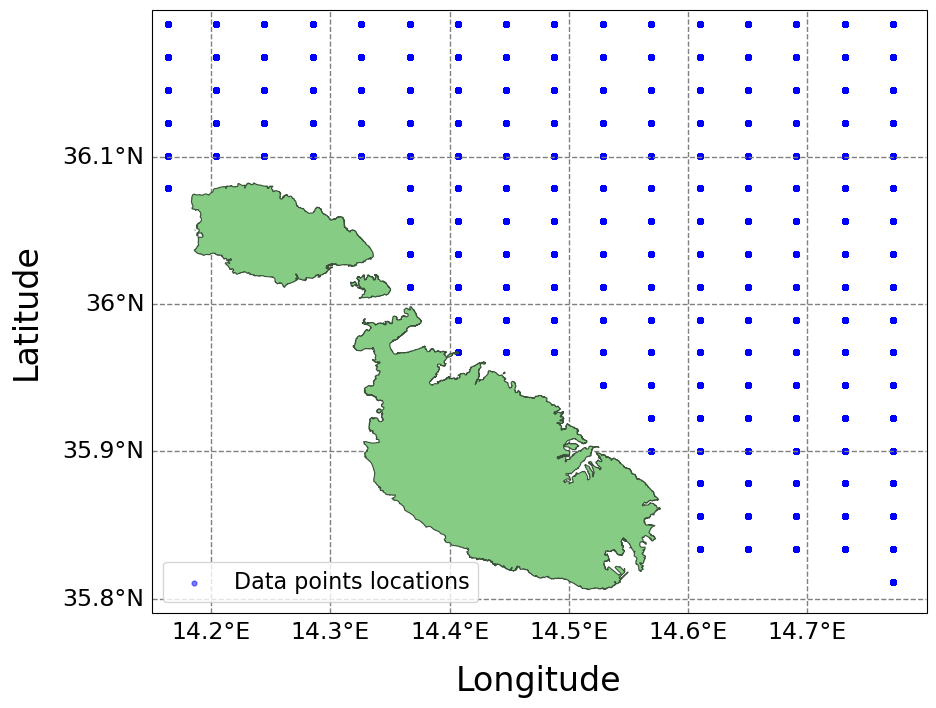

In [3]:
import pandas as pd
import xarray as xr

# Load the dataset
netcdf_file_path = "../Data/model_IO/final_SSC_Data.nc"

# Open the dataset
dataset = xr.open_dataset(netcdf_file_path)

# Convert the dataset to a pandas DataFrame and reset the index
df = dataset.to_dataframe().reset_index()

# Drop unnecessary columns from the DataFrame
df = df.drop(columns=['stdu', 'stdv', 'cov', 'velo', 'head'])

# Drop rows with NaN values in 'u' and 'v' columns
df.dropna(subset=['u', 'v'], inplace=True)

# Convert the 'time' column to datetime format
df.index = pd.to_datetime(df['time'], format='%d-%m-%Y %H:%M:%S')

# Define the boundaries for the map
boundaries = {
    'min_lon': 14.15,
    'max_lon': 14.8,
    'min_lat': 35.79,
    'max_lat': 36.2
}

# Define the vertices of a polygon to highlight a specific area on the map
polygon_coordinates = [
    (14.6, 35.87),
    (14.35, 36.01),
    (14.35, 36.09),
    (14.6, 36.09),
    (14.6, 35.87)
]

# Load the shapefile using GeoPandas
shapefile_path = '../Data/land_sea_mask/MaltaCoastline.shp'
gdf = gpd.read_file(shapefile_path).to_crs(epsg=4326)

# Prepare the plot with a geographic (Plate Carree) projection
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([boundaries['min_lon'], boundaries['max_lon'], boundaries['min_lat'], boundaries['max_lat']])

# Plot the coastline of Malta using GeoPandas
gdf.plot(ax=ax, color='#86CC85', edgecolor='#3B533B', linewidth=0.8, zorder=3)

# Plot all data points within the defined geographic boundaries
ax.scatter(df['lon'], df['lat'], s=12, color='blue', marker='o', alpha=0.5, transform=ccrs.Geodetic())

# Added label for the legend
ax.scatter(df['lon'], df['lat'], s=12, color='blue', marker='o', alpha=0.5, transform=ccrs.Geodetic(), label='Data points locations')

# Customize the plot appearance
ax.text(-0.14, 0.50, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize = 24)
ax.text(0.5, -0.14, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize = 24)

# Add gridlines to the map
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=1, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 17} 
gl.ylabel_style = {'size': 17} 

plt.legend(loc='lower left', fontsize=16)

plt.savefig('data_locations.png', bbox_inches='tight', dpi=300)

# Display the plot
plt.show()